In [1]:
#imports 
import os
import keras
import numpy as np
import matplotlib.pyplot as plt
import h5py

from keras.layers import Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, GlobalAveragePooling2D, Lambda, concatenate
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from tensorflow.python.keras._impl.keras.datasets.cifar import load_batch

#from __future__ import print_function

C:\Users\mcdonnmd\Anaconda3\envs\py35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#select a GPU
os.environ["CUDA_DEV}ICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
#load and preprocess data. Can replace this with keras scripts, but the internet connection failed for me
path = 'E:\CIFAR100\cifar-100-python'
num_classes = 100
num_train_samples = 50000
    
fpath = os.path.join(path, 'train')
x_train, y_train = load_batch(fpath, label_key='fine' + '_labels')

fpath = os.path.join(path, 'test')
x_test, y_test = load_batch(fpath, label_key='fine' + '_labels')

    
y_train = np.reshape(y_train, (len(y_train), 1))
y_test = np.reshape(y_test, (len(y_test), 1))

if K.image_data_format() == 'channels_last':
    x_train = x_train.transpose(0, 2, 3, 1)
    x_test = x_test.transpose(0, 2, 3, 1)

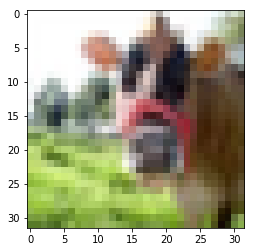

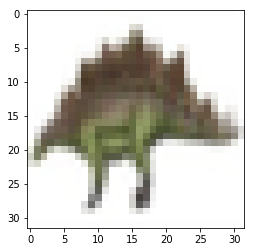

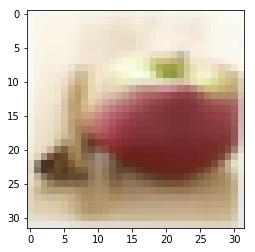

In [4]:
#visualise some examples
imgplot1 = plt.imshow(x_train[0,:,:,:])
plt.show()
imgplot2 = plt.imshow(x_train[1,:,:,:])
plt.show()
imgplot3 = plt.imshow(x_train[2,:,:,:])
plt.show()

In [5]:
# Input image dimensions and normalization
input_shape = x_train.shape[1:]

# Normalize data. This helps the exponential moving averages in keras
x_train = x_train.astype('float32')/255 #divide by 255 is done in cutout
x_test = x_test.astype('float32')/255
x_train = x_train-0.5
x_test = x_test-0.5
    
# Convert class vectors to one-hot labelled categorical matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(input_shape)

(32, 32, 3)


In [6]:
#tDefinition of the deep convolutional neural network we will use

#definition of a BN-->Relu-->Conv block
def conv_block(inputs,num_filters=16,kernel_size=3,strides=1,bn_moments_momentum=0.99,
                 learn_bn = True,wd=1e-4,UseRelu=True,UseBatchNorm = True):
    x = inputs
    if UseBatchNorm:
        x = BatchNormalization(momentum=bn_moments_momentum,center=learn_bn,scale=learn_bn)(x)
    if UseRelu:
        x = Activation('relu')(x)
    x = Conv2D(num_filters,kernel_size=kernel_size,strides=strides,padding='same',kernel_initializer='he_normal',
                  kernel_regularizer=l2(wd),use_bias=False)(x)
    return x

#main network definition
def allconvnet(input_shape,num_classes,base_filters,num_scales,blocks_per_scale,bn_moments_momentum,My_wd):
    
    # Start model definition.    

    #input layers prior to first branching
    num_filters = base_filters
    inputs = Input(shape=input_shape)       
    x = conv_block(  inputs=inputs,
                     num_filters=num_filters,
                     kernel_size=3,
                     strides=1,
                     bn_moments_momentum=bn_moments_momentum,
                     learn_bn = True,
                     wd=My_wd,
                     UseRelu=False,
                     UseBatchNorm=True)
    
    # now we go deep
    for scale in range(num_scales):
        for block in range(blocks_per_scale):
            strides = 1
            if scale > 0 and block == 0:  # first layer but not first stack
                strides = 2  # downsample
                
            #repeated bn-->ReLU--> conv
            x = conv_block(  inputs=x,
                             num_filters=num_filters,
                             kernel_size=3,
                             strides=strides, #sometimes this is 2
                             bn_moments_momentum=bn_moments_momentum,
                             learn_bn = True,
                             wd=My_wd,
                             UseRelu=True,
                             UseBatchNorm=True)

            
        #when we are here, we double the number of filters    
        num_filters *= 2

    #output block with 1x1 convolutions
    num_filters = num_classes
    x = conv_block(  inputs=x,
                     num_filters=num_filters,
                     kernel_size=1,
                     strides=1,
                     bn_moments_momentum=bn_moments_momentum,
                     learn_bn = True,
                     wd=My_wd,
                     UseRelu=True,
                     UseBatchNorm=True)
    
    #final part of network
    OutputPath = BatchNormalization(momentum=bn_moments_momentum,center=True, scale=True)(x)
    OutputPath = GlobalAveragePooling2D()(OutputPath)
    OutputPath = Activation('softmax')(OutputPath)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=OutputPath)
    return model

In [7]:
#define the model
num_classes = 100
base_filters = 16
num_scales = 3
blocks_per_scale=6
bn_moments_momentum = 0.9
my_weight_decay = 1e-4
model = allconvnet(input_shape=input_shape,
                   num_classes=num_classes,
                   base_filters=base_filters,
                   num_scales=num_scales,
                   blocks_per_scale=blocks_per_scale,
                   bn_moments_momentum=bn_moments_momentum,
                   My_wd=my_weight_decay)

#compile the model
model.compile(loss='categorical_crossentropy',
              optimizer =SGD(lr=0.1,decay=0, momentum=0.9, nesterov=False),
              metrics=['accuracy'])

In [8]:
#display the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        432       
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 16)        2304      
_________________________________________________________________
batch_normalization_3 (Batch (None, 32, 32, 16)        64        
__________

In [9]:
#learning rate schedule. Set the learning rate to 0.1 for 10 epochs and 0.01 for 11-13 and then 0 for epoch 14
def lr_schedule(epoch):
    lr = 0.1
    if epoch > 10:
        lr *= 1e-1
    elif epoch > 13:
        lr = 0
    print('Learning rate: ', lr)
    return lr

In [10]:
#get training samples with flip and pad/crop augmentation
datagen = ImageDataGenerator(    width_shift_range=4/32,
                                 height_shift_range=4/32,
                                 horizontal_flip=True,
                                 fill_mode='nearest')

#learning rate callback
lr_scheduler = LearningRateScheduler(lr_schedule)
callbacks = [lr_scheduler]

batch_size = 125  
epochs = 14

# Fit the model on the batches generated by datagen.flow().
# This will do preprocessing and realtime data augmentation:
# Training parameters
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                              validation_data=(x_test, y_test),
                              epochs=epochs,
                              verbose=1,
                              workers=1,
                              callbacks=callbacks)

Epoch 1/14
Learning rate:  0.1
400/400 [==============================] - 27s 67ms/step - loss: 4.1988 - acc: 0.0719 - val_loss: 4.0221 - val_acc: 0.0977
Epoch 2/14
Learning rate:  0.1
400/400 [==============================] - 21s 52ms/step - loss: 3.7510 - acc: 0.1380 - val_loss: 3.7809 - val_acc: 0.1451
Epoch 3/14
Learning rate:  0.1
400/400 [==============================] - 21s 51ms/step - loss: 3.4790 - acc: 0.1908 - val_loss: 3.6276 - val_acc: 0.1728
Epoch 4/14
Learning rate:  0.1
400/400 [==============================] - 21s 52ms/step - loss: 3.2285 - acc: 0.2405 - val_loss: 3.4166 - val_acc: 0.2259
Epoch 5/14
Learning rate:  0.1
400/400 [==============================] - 21s 52ms/step - loss: 3.0102 - acc: 0.2848 - val_loss: 2.9873 - val_acc: 0.2999
Epoch 6/14
Learning rate:  0.1
400/400 [==============================] - 21s 52ms/step - loss: 2.8503 - acc: 0.3183 - val_loss: 2.8421 - val_acc: 0.3250
Epoch 7/14
Learning rate:  0.1
400/400 [==============================] - 21

In [11]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 5s 501us/step
Test accuracy: 0.5075


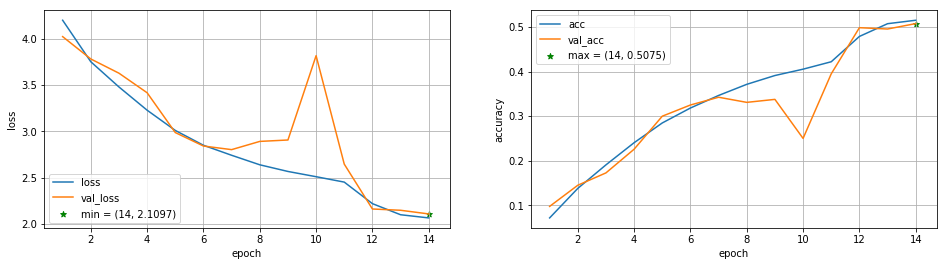

In [12]:
#plot function
def plot_history(history, gen=False):
    plt.figure(figsize=(16,4))
    plt.subplot(121)
    plt.plot(range(1, epochs+1), history.history['loss'], label='loss')
    plt.plot(range(1, epochs+1), history.history['val_loss'], label='val_loss')
    min_pos = np.argmin(history.history['val_loss'])
    min_value = history.history['val_loss'][min_pos]
    plt.scatter(min_pos+1, min_value, color='green', marker='*', label='min = ({}, {:.4f})'.format(min_pos+1, min_value))
    plt.ylabel('loss'); plt.xlabel('epoch'); plt.legend(); plt.grid()
    plt.subplot(122)
    plt.plot(range(1, epochs+1), history.history['acc'], label='acc')
    plt.plot(range(1, epochs+1), history.history['val_acc'], label='val_acc')
    max_pos = np.argmax(history.history['val_acc'])
    max_value = history.history['val_acc'][max_pos]
    plt.scatter(max_pos+1, max_value, color='green', marker='*', label='max = ({}, {:.4f})'.format(max_pos+1, max_value))
    plt.ylabel('accuracy'); plt.xlabel('epoch'); plt.legend(); plt.grid()
   # plt.savefig(_DIR_ + model_name + ('_gen' if gen else '') + '.png')

plot_history(history, gen=True)

In [13]:
#the actual network model definition
def allconvnet_no_bn(input_shape,num_classes,base_filters,num_scales,blocks_per_scale,bn_moments_momentum,My_wd):
    
    # Start model definition.    

    #input layers prior to first branching
    num_filters = base_filters
    inputs = Input(shape=input_shape)       
    x = conv_block(  inputs=inputs,
                     num_filters=num_filters,
                     kernel_size=3,
                     strides=1,
                     bn_moments_momentum=bn_moments_momentum,
                     learn_bn = True,
                     wd=My_wd,
                     UseRelu=False,
                     UseBatchNorm=False)
    
    # now we go deep
    for scale in range(num_scales):
        for block in range(blocks_per_scale):
            strides = 1
            if scale > 0 and block == 0:  # first layer but not first stack
                strides = 2  # downsample
                
            #repeated bn-->ReLU--> conv
            x = conv_block(  inputs=x,
                             num_filters=num_filters,
                             kernel_size=3,
                             strides=strides, #sometimes this is 2
                             bn_moments_momentum=bn_moments_momentum,
                             learn_bn = True,
                             wd=My_wd,
                             UseRelu=True,
                             UseBatchNorm=False)

            
        #when we are here, we double the number of filters    
        num_filters *= 2

    #output block with 1x1 convolutions
    num_filters = num_classes
    x = conv_block(  inputs=x,
                     num_filters=num_filters,
                     kernel_size=1,
                     strides=1,
                     bn_moments_momentum=bn_moments_momentum,
                     learn_bn = True,
                     wd=My_wd,
                     UseRelu=True,
                     UseBatchNorm=False)
    
    #final part of network
   # OutputPath = BatchNormalization(momentum=bn_moments_momentum,center=True, scale=True)(x)
    OutputPath = GlobalAveragePooling2D()(x)
    OutputPath = Activation('softmax')(OutputPath)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=OutputPath)
    return model

In [14]:
#define the model
model_no_bn = allconvnet_no_bn(input_shape=input_shape,
                   num_classes=num_classes,
                   base_filters=base_filters,
                   num_scales=num_scales,
                   blocks_per_scale=blocks_per_scale,
                   bn_moments_momentum=bn_moments_momentum,
                   My_wd=my_weight_decay)

#compile the model
model_no_bn.compile(loss='categorical_crossentropy',
              optimizer =SGD(lr=0.1,decay=0, momentum=0.9, nesterov=False),
              metrics=['accuracy'])

In [15]:
#get training samples with flip and pad/crop augmentation
datagen = ImageDataGenerator(    width_shift_range=4/32,
                                 height_shift_range=4/32,
                                 horizontal_flip=True,
                                 fill_mode='nearest')

#learning rate callback
lr_scheduler = LearningRateScheduler(lr_schedule)
callbacks = [lr_scheduler]

batch_size = 125  
epochs = 14

# Fit the model on the batches generated by datagen.flow().
# This will do preprocessing and realtime data augmentation:
# Training parameters
history1 = model_no_bn.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                              validation_data=(x_test, y_test),
                              epochs=2,
                              verbose=1,
                              workers=1,
                              callbacks=callbacks)

Epoch 1/2
Learning rate:  0.1
400/400 [==============================] - 20s 49ms/step - loss: 4.7215 - acc: 0.0106 - val_loss: 4.7209 - val_acc: 0.0111
Epoch 2/2
Learning rate:  0.1
400/400 [==============================] - 18s 45ms/step - loss: 4.7122 - acc: 0.0112 - val_loss: 4.7038 - val_acc: 0.0111


In [16]:
#learning rate schedule for no BN: we had to reduce the maximum learning rate
def lr_schedule_no_bn(epoch):
    lr = 0.01
    if epoch > 10:
        lr *= 1e-1
    elif epoch > 13:
        lr = 0
    print('Learning rate: ', lr)
    return lr

In [17]:
#define the model
model_no_bn = allconvnet_no_bn(input_shape=input_shape,
                   num_classes=num_classes,
                   base_filters=base_filters,
                   num_scales=num_scales,
                   blocks_per_scale=blocks_per_scale,
                   bn_moments_momentum=bn_moments_momentum,
                   My_wd=my_weight_decay)

#compile the model
model_no_bn.compile(loss='categorical_crossentropy',
              optimizer =SGD(lr=0.1,decay=0, momentum=0.9, nesterov=False),
              metrics=['accuracy'])


In [18]:
#get training samples with flip and pad/crop augmentation
datagen = ImageDataGenerator(    width_shift_range=4/32,
                                 height_shift_range=4/32,
                                 horizontal_flip=True,
                                 fill_mode='nearest')

#learning rate callback
lr_scheduler = LearningRateScheduler(lr_schedule_no_bn)
callbacks = [lr_scheduler]

batch_size = 125  
epochs = 14

# Fit the model on the batches generated by datagen.flow().
# This will do preprocessing and realtime data augmentation:
# Training parameters
history2 = model_no_bn.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                              validation_data=(x_test, y_test),
                              epochs=14,
                              verbose=1,
                              workers=1,
                              callbacks=callbacks)

Epoch 1/14
Learning rate:  0.01
400/400 [==============================] - 20s 50ms/step - loss: 4.7162 - acc: 0.0100 - val_loss: 4.6644 - val_acc: 0.0101
Epoch 2/14
Learning rate:  0.01
400/400 [==============================] - 18s 45ms/step - loss: 4.6271 - acc: 0.0108 - val_loss: 4.6077 - val_acc: 0.0126
Epoch 3/14
Learning rate:  0.01
400/400 [==============================] - 18s 46ms/step - loss: 4.5920 - acc: 0.0127 - val_loss: 4.5632 - val_acc: 0.0156
Epoch 4/14
Learning rate:  0.01
400/400 [==============================] - 18s 46ms/step - loss: 4.5665 - acc: 0.0178 - val_loss: 4.5333 - val_acc: 0.0268
Epoch 5/14
Learning rate:  0.01
400/400 [==============================] - 18s 45ms/step - loss: 4.5302 - acc: 0.0261 - val_loss: 4.4860 - val_acc: 0.0302
Epoch 6/14
Learning rate:  0.01
400/400 [==============================] - 18s 45ms/step - loss: 4.4766 - acc: 0.0356 - val_loss: 4.4098 - val_acc: 0.0414
Epoch 7/14
Learning rate:  0.01
400/400 [=============================

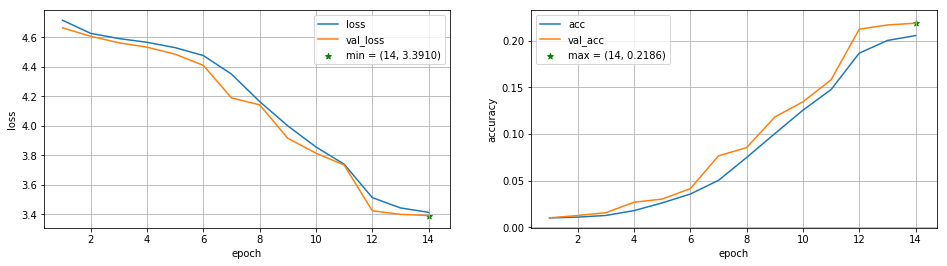

In [19]:
#plot function
def plot_history(history, gen=False):
    plt.figure(figsize=(16,4))
    plt.subplot(121)
    plt.plot(range(1, epochs+1), history.history['loss'], label='loss')
    plt.plot(range(1, epochs+1), history.history['val_loss'], label='val_loss')
    min_pos = np.argmin(history.history['val_loss'])
    min_value = history.history['val_loss'][min_pos]
    plt.scatter(min_pos+1, min_value, color='green', marker='*', label='min = ({}, {:.4f})'.format(min_pos+1, min_value))
    plt.ylabel('loss'); plt.xlabel('epoch'); plt.legend(); plt.grid()
    plt.subplot(122)
    plt.plot(range(1, epochs+1), history.history['acc'], label='acc')
    plt.plot(range(1, epochs+1), history.history['val_acc'], label='val_acc')
    max_pos = np.argmax(history.history['val_acc'])
    max_value = history.history['val_acc'][max_pos]
    plt.scatter(max_pos+1, max_value, color='green', marker='*', label='max = ({}, {:.4f})'.format(max_pos+1, max_value))
    plt.ylabel('accuracy'); plt.xlabel('epoch'); plt.legend(); plt.grid()
   # plt.savefig(_DIR_ + model_name + ('_gen' if gen else '') + '.png')

plot_history(history=history2, gen=True)

In [20]:
#Network 3: Use Exponential Linear Units (ELUs)

#definition of a block
def conv_block_elu(inputs,num_filters=16,kernel_size=3,strides=1,
                 learn_bn = True,wd=1e-4,UseElu= True):
    x = inputs
    if UseElu:
        x = Activation('elu')(x)
    x = Conv2D(num_filters,kernel_size=kernel_size,strides=strides,padding='same',kernel_initializer='he_normal',
                  kernel_regularizer=l2(wd),use_bias=False)(x)
    return x

#the actual network model definition
def allconvnet_elu(input_shape,num_classes,base_filters,num_scales,blocks_per_scale,bn_moments_momentum,My_wd):
    
    # Start model definition.    

    #input layers prior to first branching
    num_filters = base_filters
    inputs = Input(shape=input_shape)       
    x = conv_block_elu(  inputs=inputs,
                     num_filters=num_filters,
                     kernel_size=3,
                     strides=1,
                     learn_bn = True,
                     wd=My_wd,
                     UseElu=False)
    
    # now we go deep
    for scale in range(num_scales):
        for block in range(blocks_per_scale):
            strides = 1
            if scale > 0 and block == 0:  # first layer but not first stack
                strides = 2  # downsample
                
            #repeated bn-->ReLU--> conv
            x = conv_block_elu(  inputs=x,
                             num_filters=num_filters,
                             kernel_size=3,
                             strides=strides,
                             learn_bn = True,
                             wd=My_wd,
                             UseElu=True)

            
        #when we are here, we double the number of filters    
        num_filters *= 2

    #output block with 1x1 convolutions
    num_filters = num_classes
    x = conv_block_elu(  inputs=x,
                     num_filters=num_filters,
                     kernel_size=1,
                     strides=1,
                     learn_bn = True,
                     wd=My_wd,
                     UseElu=True)
    
    #final part of network
   # OutputPath = BatchNormalization(momentum=bn_moments_momentum,center=True, scale=True)(x)
    OutputPath = GlobalAveragePooling2D()(x)
    OutputPath = Activation('softmax')(OutputPath)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=OutputPath)
    return model

In [21]:
#define the model
model_elu = allconvnet_elu(input_shape=input_shape,
                   num_classes=num_classes,
                   base_filters=base_filters,
                   num_scales=num_scales,
                   blocks_per_scale=blocks_per_scale,
                   bn_moments_momentum=bn_moments_momentum,
                   My_wd=my_weight_decay)

#compile the model
model_elu.compile(loss='categorical_crossentropy',
              optimizer =SGD(lr=0.1,decay=0, momentum=0.9, nesterov=False),
              metrics=['accuracy'])


In [22]:
#get training samples with flip and pad/crop augmentation
datagen = ImageDataGenerator(    width_shift_range=4/32,
                                 height_shift_range=4/32,
                                 horizontal_flip=True,
                                 fill_mode='nearest')

#learning rate callback
lr_scheduler = LearningRateScheduler(lr_schedule_no_bn)
callbacks = [lr_scheduler]

batch_size = 125  
epochs = 14

# Fit the model on the batches generated by datagen.flow().
# This will do preprocessing and realtime data augmentation:
# Training parameters
history3 = model_elu.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                              validation_data=(x_test, y_test),
                              epochs=14,
                              verbose=1,
                              workers=1,
                              callbacks=callbacks)

Epoch 1/14
Learning rate:  0.01
400/400 [==============================] - 19s 49ms/step - loss: 4.2906 - acc: 0.0602 - val_loss: 3.9371 - val_acc: 0.1023
Epoch 2/14
Learning rate:  0.01
400/400 [==============================] - 18s 44ms/step - loss: 3.8072 - acc: 0.1247 - val_loss: 3.6006 - val_acc: 0.1608
Epoch 3/14
Learning rate:  0.01
400/400 [==============================] - 18s 45ms/step - loss: 3.5272 - acc: 0.1749 - val_loss: 3.3703 - val_acc: 0.1959
Epoch 4/14
Learning rate:  0.01
400/400 [==============================] - 18s 46ms/step - loss: 3.3212 - acc: 0.2117 - val_loss: 3.2232 - val_acc: 0.2240
Epoch 5/14
Learning rate:  0.01
400/400 [==============================] - 18s 46ms/step - loss: 3.1437 - acc: 0.2422 - val_loss: 3.0781 - val_acc: 0.2590
Epoch 6/14
Learning rate:  0.01
400/400 [==============================] - 18s 45ms/step - loss: 2.9809 - acc: 0.2753 - val_loss: 2.9748 - val_acc: 0.2761
Epoch 7/14
Learning rate:  0.01
400/400 [=============================

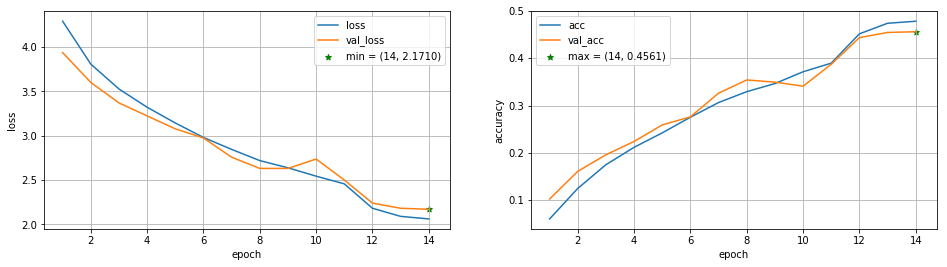

In [23]:
#plot function
def plot_history(history, gen=False):
    plt.figure(figsize=(16,4))
    plt.subplot(121)
    plt.plot(range(1, epochs+1), history.history['loss'], label='loss')
    plt.plot(range(1, epochs+1), history.history['val_loss'], label='val_loss')
    min_pos = np.argmin(history.history['val_loss'])
    min_value = history.history['val_loss'][min_pos]
    plt.scatter(min_pos+1, min_value, color='green', marker='*', label='min = ({}, {:.4f})'.format(min_pos+1, min_value))
    plt.ylabel('loss'); plt.xlabel('epoch'); plt.legend(); plt.grid()
    plt.subplot(122)
    plt.plot(range(1, epochs+1), history.history['acc'], label='acc')
    plt.plot(range(1, epochs+1), history.history['val_acc'], label='val_acc')
    max_pos = np.argmax(history.history['val_acc'])
    max_value = history.history['val_acc'][max_pos]
    plt.scatter(max_pos+1, max_value, color='green', marker='*', label='max = ({}, {:.4f})'.format(max_pos+1, max_value))
    plt.ylabel('accuracy'); plt.xlabel('epoch'); plt.legend(); plt.grid()
   # plt.savefig(_DIR_ + model_name + ('_gen' if gen else '') + '.png')

plot_history(history=history3, gen=True)

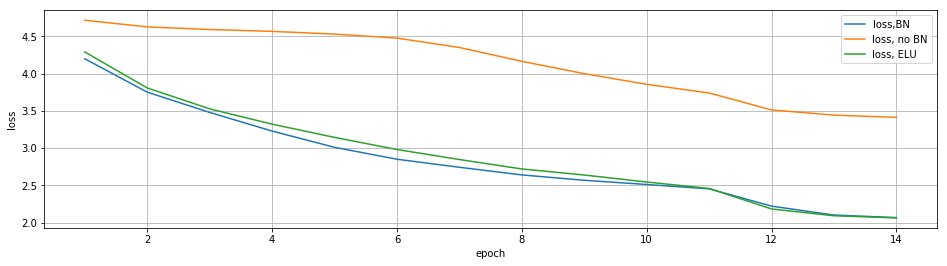

In [30]:
#Do comparison plot for training loss
plt.figure(figsize=(16,4))
plt.plot(range(1, epochs+1), history.history['loss'], label='loss,BN')
#plt.plot(range(1, 2), history1.history['loss'], label='loss')
plt.plot(range(1, epochs+1), history2.history['loss'], label='loss, no BN')
plt.plot(range(1, epochs+1), history3.history['loss'], label='loss, ELU')
plt.ylabel('loss'); plt.xlabel('epoch'); plt.legend(); plt.grid()

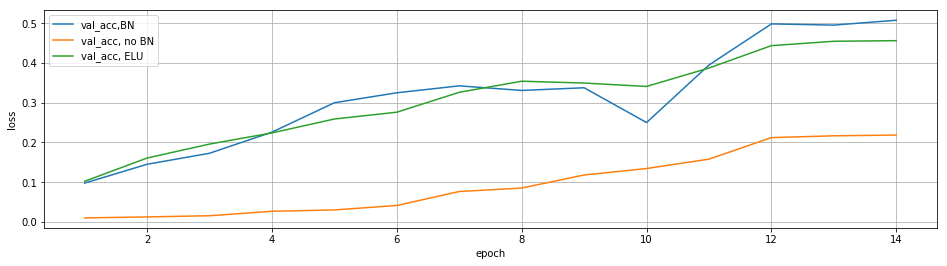

In [31]:
#Do comparison plot for test accuracy
plt.figure(figsize=(16,4))
plt.plot(range(1, epochs+1), history.history['val_acc'], label='val_acc,BN')
#plt.plot(range(1, 2), history1.history['loss'], label='loss')
plt.plot(range(1, epochs+1), history2.history['val_acc'], label='val_acc, no BN')
plt.plot(range(1, epochs+1), history3.history['val_acc'], label='val_acc, ELU')
plt.ylabel('loss'); plt.xlabel('epoch'); plt.legend(); plt.grid()